# Import

In [9]:
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import poisson
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor

SEED = 42

ROOT_PATH = 'hexp'

In [2]:
def line_plot(y_test, y_pred, plot_value, value, plot_name=None):

    plot_data = [('white', 'red', '#4682B4', ''), ('white', 'black', 'gray', '_colored')]
    for color, marker_color, line_color, suffix in plot_data:
        plt.figure(figsize=(8, 4))  # Create separate figures
        sns.lineplot(y_test, label='Истинное значение', color=color, marker='o', markersize=5, markerfacecolor=marker_color)
        sns.lineplot(y_pred, label='Оцененное значение', color=line_color)  # Simplified
        plt.xlim(0, plot_value)
        plt.ylim(0, round(max(test_intervals_Y[:plot_value, value])))
        plt.xlabel('Количество данных', fontsize=12)
        plt.ylabel('Значение данных', fontsize=12)
        plt.grid(alpha=0.5, color='black')
        plt.legend(loc=1) # Add a legend to distinguish lines

        filename = f'{plot_name}{suffix}.pdf' if plot_name else None
        if filename:
            plt.savefig(f'{filename}', bbox_inches="tight")


def scatter_plot(y_test, y_pred, lim_value, plot_name=None):
    plot_data = [(None, ''), ('grey', '_colored')]  # Store plot parameters
    for color, suffix in plot_data:
        plt.figure(figsize=(8, 4))  # Create new figure for each plot
        sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, color=color)  # Use color directly
        sns.lineplot(x=[0, lim_value], y=[0, lim_value], color='black')
        plt.xlim(0, lim_value)
        plt.ylim(0, lim_value)
        plt.xlabel('Истинные значения', fontsize=12)
        plt.ylabel('Предсказанные значения', fontsize=12)
        plt.grid(alpha=0.5, color='black')

        filename = f'{plot_name}{suffix}.pdf' if plot_name else None
        if filename:
            plt.savefig(f'{filename}', bbox_inches="tight")

def reccur_potok(p, lmbd1, lmbd2):
    uniform_random = np.random.uniform(0, 1)
    component = uniform_random <= p

    random_values = np.where(
        component,
        -np.log(np.random.uniform(0, 1)) / lmbd1,  # Если λ1
        -np.log(np.random.uniform(0, 1)) / lmbd2   # Если λ2
    )
    return random_values

def gen_recurr(row, col, y_pred1, y_pred2, y_pred3):
    time_list = np.zeros((row, col))
    l1_list = y_pred1
    l2_list = y_pred2
    p_list = y_pred3

    for i in range(row):
        time = 0
        for j in range(col):
            time += reccur_potok(p_list[i], l1_list[i], l2_list[i])
            time_list[i, j] = time
    df_prov = pd.DataFrame(time_list)
    return df_prov

def print_curve_metrics(X_test_interval, df_prov_interval, itog_itog_list):
    relative_error_mean_list = []
    relative_error_std_list = []
    for i in range(X_test_interval.shape[0]):
        relative_error_mean_list.append(abs(X_test_interval.iloc[i].mean() - df_prov_interval.iloc[i].mean()) / X_test_interval.iloc[i].mean())
        relative_error_std_list.append(abs(X_test_interval.iloc[i].std() - df_prov_interval.iloc[i].std()) / X_test_interval.iloc[i].std())

    abs_list = []
    abs_itog_list = itog_itog_list
    for i in range(X_test_interval.shape[0]):
        for j in range(X_test_interval.shape[1]):
            abs_itog_list[i][j] = abs(itog_itog_list[i][j])
        abs_list.append(max(itog_itog_list[i]))

    metrics_df = pd.DataFrame({
        'relative_error_mean': relative_error_mean_list,
        'relative_error_std': relative_error_std_list,
        'abs_list': abs_list
    })
    
    test_result_mean = {
        'relative_error_mean_mean': metrics_df['relative_error_mean'].mean(),
        'relative_error_mean_median': metrics_df['relative_error_mean'].median(),
        'relative_error_std_mean': metrics_df['relative_error_std'].mean(),
        'relative_error_std_median': metrics_df['relative_error_std'].median(),
        'abs_mean': metrics_df['abs_list'].mean(),
        'abs_median': metrics_df['abs_list'].median()
    }

    metrics_mean_df = pd.DataFrame([test_result_mean])
    for key, value in test_result_mean.items():
        print(f'{key}:\t{value:.3f}') 
    return 


def evaluate_regression(y_true, y_pred, param_name):
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    print(f"\n{param_name}")
    print(f'MAE: {mae:.3f}')
    print(f'MSE: {mse:.3f}')
    print(f'RMSE: {rmse:.3f}')
    print(f'MAPE: {mape:.3f}%')
    print(f'R² Score: {r2:.3f}')
    return # No need to explicitly return None

def get_intervals_from_df(df):
    intervals = df.diff(axis=1).iloc[:, 1:]
    intervals.columns = range(intervals.shape[1])
    return intervals

def calculate_statistics(X):
    n_observations = X.shape[0]
    stat_M = np.zeros((n_observations, 10))

    # Векторизованные вычисления для основных статистик
    stat_M[:, 0] = np.mean(X, axis=1)
    stat_M[:, 1] = np.var(X, axis=1)
    stat_M[:, 2] = np.std(X, axis=1)
    stat_M[:, 3] = stat_M[:, 2] / stat_M[:, 0]  # Коэффициент вариации

    # Квантили. Избегаем повторного вычисления квантилей
    quantiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
    quantiles_values = np.quantile(X, quantiles, axis=1)
    stat_M[:, 4:10] = quantiles_values.T # Транспонируем, чтобы правильно разместить

    return stat_M

# Read and split

In [3]:
df = pd.read_csv("/home/jupyter/datasphere/datasets/datasets/hexp.csv", sep=",", index_col=0)

In [4]:
df.shape

(10000, 10004)

In [5]:
df.head()

0         1         2         3  ...     lmbd1     lmbd2    p      lmbd
0  1.685013  2.497243  2.503073  3.743180  ...  0.556858  4.094411  0.8  0.673184
1  0.323733  0.632626  1.367274  3.017643  ...  2.426465  2.261901  0.6  2.357847
2  0.632925  1.314693  1.457913  1.474312  ...  4.475875  3.462100  0.4  3.807011
3  0.450661  1.404486  1.442100  1.716287  ...  4.619581  0.476268  0.3  0.651592
4  0.435042  0.578830  1.309719  1.668515  ...  0.389715  3.228545  0.2  1.314085

[5 rows x 10004 columns]

In [6]:
intervals_df = get_intervals_from_df(df.iloc[0:10000, :10000])
intervals_df['lmbd1'] = df['lmbd1']
intervals_df['lmbd2'] = df['lmbd2']
intervals_df['p'] = df['p']
intervals_df['lmbd'] = df['lmbd']

In [7]:
intervals_df.head()

0         1         2         3  ...     lmbd1     lmbd2    p      lmbd
0  0.812229  0.005830  1.240107  0.675604  ...  0.556858  4.094411  0.8  0.673184
1  0.308893  0.734648  1.650369  0.202724  ...  2.426465  2.261901  0.6  2.357847
2  0.681768  0.143220  0.016400  0.178014  ...  4.475875  3.462100  0.4  3.807011
3  0.953825  0.037615  0.274186  0.426208  ...  4.619581  0.476268  0.3  0.651592
4  0.143788  0.730889  0.358796  0.015722  ...  0.389715  3.228545  0.2  1.314085

[5 rows x 10003 columns]

In [10]:
train_intervals_df, test_intervals_df = train_test_split(intervals_df, train_size=0.8, random_state=SEED, shuffle=True)

In [11]:
test_intervals_df, val_intervals_df = train_test_split(test_intervals_df, train_size=0.7, random_state=SEED, shuffle=True)

In [12]:
train_intervals_X = np.array(train_intervals_df)[:, :9999]
train_intervals_Y = np.array(train_intervals_df)[:, 9999:]
test_intervals_X = np.array(test_intervals_df)[:, :9999]
test_intervals_Y = np.array(test_intervals_df)[:, 9999:]
val_intervals_X = np.array(val_intervals_df)[:, :9999]
val_intervals_Y = np.array(val_intervals_df)[:, 9999:]

# Метод моментов

In [102]:
mean_empirical = test_intervals_X.mean(axis=1)
moment2_empirical = (test_intervals_X**2).mean(axis=1)
moment3_empirical = (test_intervals_X**3).mean(axis=1)
var_emp = test_intervals_X.var(axis=1)

In [103]:
cv = np.sqrt(moment2_empirical-mean_empirical**2)/mean_empirical
p = 0.5*(1-np.sqrt((cv-1)/(cv+1)))
l1 = 2*(p/mean_empirical)
l2 = 2*((1-p)/mean_empirical)

/tmp/ipykernel_2452/3011555504.py:2: RuntimeWarning: invalid value encountered in sqrt
  p = 0.5*(1-np.sqrt((cv-1)/(cv+1)))


In [144]:
def evaluate_regression(y_true, y_pred, param_name):
    # Handle NaN values: Filter out NaN values in both y_true and y_pred at the same indices
    nan_mask = np.isnan(y_pred)
    y_true = y_true[~nan_mask]
    y_pred = y_pred[~nan_mask]

    # Check if there are any valid values left after removing NaNs
    if len(y_true) == 0:
        print(f"\n{param_name}")
        print("Warning: No valid data points remaining after removing NaN values.  Cannot calculate metrics.")
        return

    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    print(f"\n{param_name}")
    print(f'MAE: {mae:.3f}')
    print(f'MSE: {mse:.3f}')
    print(f'RMSE: {rmse:.3f}')
    print(f'MAPE: {mape:.3f}%')
    print(f'R² Score: {r2:.3f}')

In [145]:
evaluate_regression(test_intervals_Y[:, 0], l2, "value1")
evaluate_regression(test_intervals_Y[:, 1], l1, "value2")
evaluate_regression(test_intervals_Y[:, 2], np.round(p, decimals=1), "value3")


value1
MAE: 1.979
MSE: 8.155
RMSE: 2.856
MAPE: 48.715%
R² Score: 0.045

value2
MAE: 0.628
MSE: 1.189
RMSE: 1.090
MAPE: 23.980%
R² Score: 0.432

value3
MAE: 0.246
MSE: 0.088
RMSE: 0.297
MAPE: 63.248%
R² Score: -0.590


# Catboost

## Catboost интервалы

In [9]:
# %pip install catboost

In [14]:
params = {
    "loss_function": "MultiRMSE",
    "verbose": 100,
    "random_seed": SEED,
    #"task_type": "GPU",  # Уберите, если у вас нет GPU
    "iterations": 2000,
    "early_stopping_rounds": 200,
    #"l2_leaf_reg": 3,
    #"depth": 8,
    #"learning_rate": 0.03
}

inter = CatBoostRegressor(**params)

# Обучение с использованием валидационной выборки
inter.fit(train_intervals_X, train_intervals_Y, eval_set=(val_intervals_X, val_intervals_Y), use_best_model=True)

0:	learn: 3.6316050	test: 3.6037483	best: 3.6037483 (0)	total: 3.37s	remaining: 1h 52m 22s
100:	learn: 2.5393531	test: 2.6165960	best: 2.6165960 (100)	total: 1m	remaining: 18m 58s
200:	learn: 2.2523369	test: 2.4059708	best: 2.4059708 (200)	total: 1m 54s	remaining: 17m 6s
300:	learn: 2.0698391	test: 2.2899030	best: 2.2899030 (300)	total: 2m 48s	remaining: 15m 50s
400:	learn: 1.9110765	test: 2.2176626	best: 2.2176626 (400)	total: 3m 41s	remaining: 14m 44s
500:	learn: 1.7829848	test: 2.1648965	best: 2.1648965 (500)	total: 4m 35s	remaining: 13m 43s
600:	learn: 1.6784495	test: 2.1289457	best: 2.1289457 (600)	total: 5m 28s	remaining: 12m 44s
700:	learn: 1.5913621	test: 2.1025557	best: 2.1025557 (700)	total: 6m 21s	remaining: 11m 46s
800:	learn: 1.5133430	test: 2.0816298	best: 2.0816298 (800)	total: 7m 14s	remaining: 10m 50s
900:	learn: 1.4445038	test: 2.0656205	best: 2.0656205 (900)	total: 8m 7s	remaining: 9m 54s
1000:	learn: 1.3831580	test: 2.0475414	best: 2.0475414 (1000)	total: 9m	remaini

In [13]:
pred = inter.predict(test_intervals_X)

In [16]:
inter.save_model(ROOT_PATH + "_inter")

In [12]:
inter = CatBoostRegressor() 
inter.load_model('/home/jupyter/datasphere/project/hexp/models/hexp_inter')
pred = inter.predict(test_intervals_X)

### Метрики

In [14]:
evaluate_regression(test_intervals_Y[:, 0], pred[:, 0], "value1")
evaluate_regression(test_intervals_Y[:, 1], pred[:, 1], "value2")
evaluate_regression(test_intervals_Y[:, 2], pred[:, 2], "value3")
evaluate_regression(test_intervals_Y[:, 3], pred[:, 3], "value4")


value1
MAE: 1.349
MSE: 3.236
RMSE: 1.799
MAPE: 87.356%
R² Score: 0.609

value2
MAE: 0.771
MSE: 1.003
RMSE: 1.002
MAPE: 98.425%
R² Score: 0.522

value3
MAE: 0.182
MSE: 0.047
RMSE: 0.217
MAPE: 62.755%
R² Score: 0.159

value4
MAE: 0.240
MSE: 0.145
RMSE: 0.381
MAPE: 19.376%
R² Score: 0.955


In [20]:
train_df, test_df = train_test_split(df, train_size=0.8, random_state=SEED, shuffle=True)
test_df, val_df = train_test_split(test_df, train_size=0.7, random_state=SEED, shuffle=True)

test_df_X = np.array(test_df)[:, :10000]

test_df_gen = gen_recurr(test_df_X.shape[0], test_df_X.shape[1], pred[:,0], pred[:,1], pred[:,2])

test_interval_df_gen = get_intervals_from_df(test_df_gen.iloc[:, :10000])

In [21]:
a = test_df_X[0:test_df_X.shape[0], :test_df_X.shape[1]]
b = np.array(test_df_gen.iloc[0:test_df_X.shape[0], :test_df_X.shape[1]])

itog_itog_list = []

for i in range(test_df_X.shape[0]):
    itog_list = []
    n_cols = test_df_X.shape[1] # Store this value to avoid repeated access

    if np.max(a[i]) > np.max(b[i]): # Use NumPy's max for efficiency
        counter1 = 0
        counter2 = 0
        while counter1 < n_cols and counter2 < n_cols: #Ensure no index errors
            diff = counter1 - counter2
            if a[i][counter1] < b[i][counter2]:
                counter1 += 1
            elif a[i][counter1] > b[i][counter2]:
                counter2 += 1
            else:
                counter1 += 1
                counter2 += 1
            itog_list.append(abs(diff))
    else:
        counter1 = 0
        counter2 = 0
        while counter1 < n_cols and counter2 < n_cols: #Ensure no index errors
            diff = counter1 - counter2
            if a[i][counter1] < b[i][counter2]:
                counter1 += 1
            elif a[i][counter1] > b[i][counter2]:
                counter2 += 1
            else:
                counter1 += 1
                counter2 += 1
            itog_list.append(abs(diff))

    itog_itog_list.append(itog_list)

In [22]:
print_curve_metrics(test_intervals_df.iloc[:, :9999], test_interval_df_gen, itog_itog_list)

relative_error_mean_mean:	0.230
relative_error_mean_median:	0.141
relative_error_std_mean:	0.281
relative_error_std_median:	0.195
abs_mean:	2221.719
abs_median:	1401.000


### Рисунки

In [16]:
model_path = '_inter'

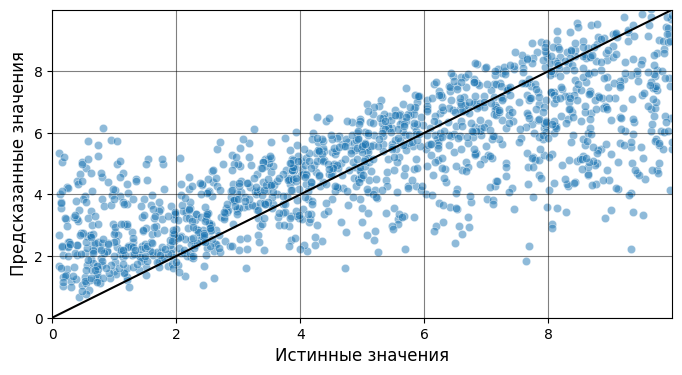

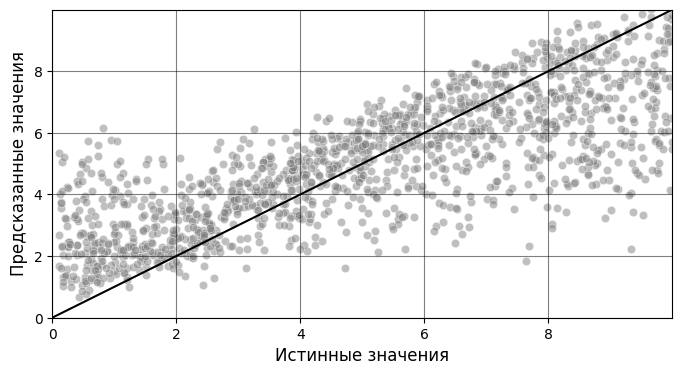

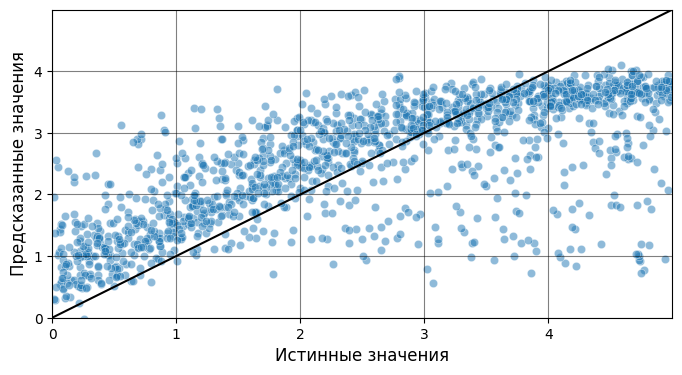

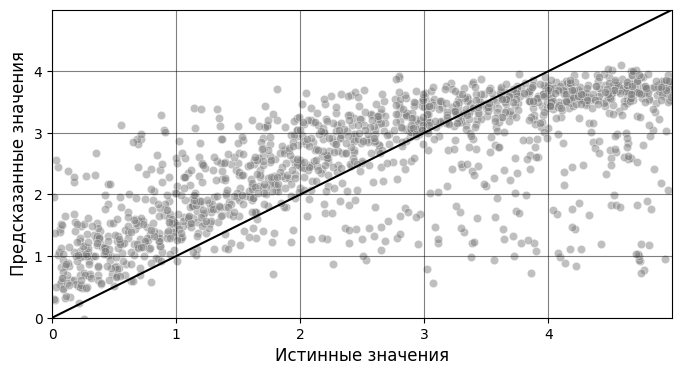

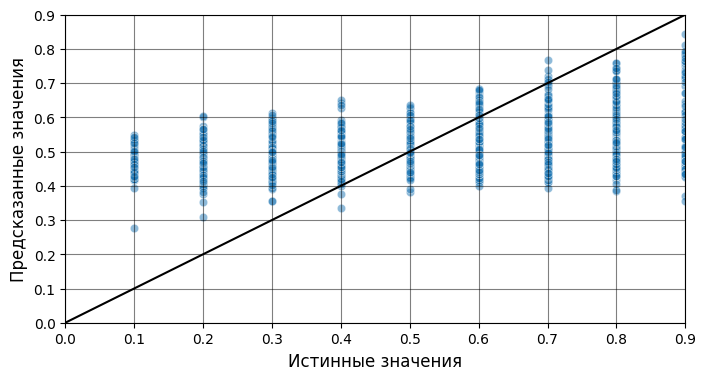

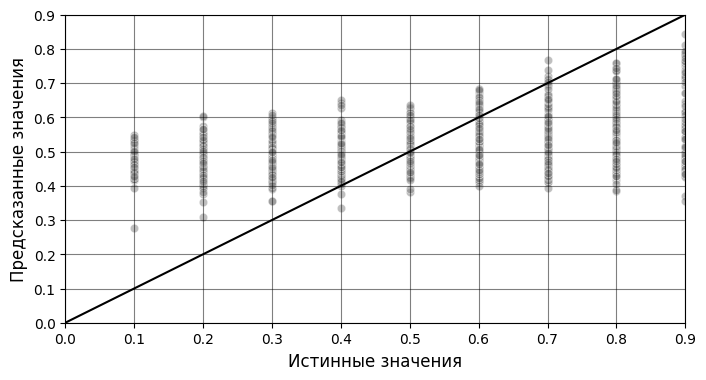

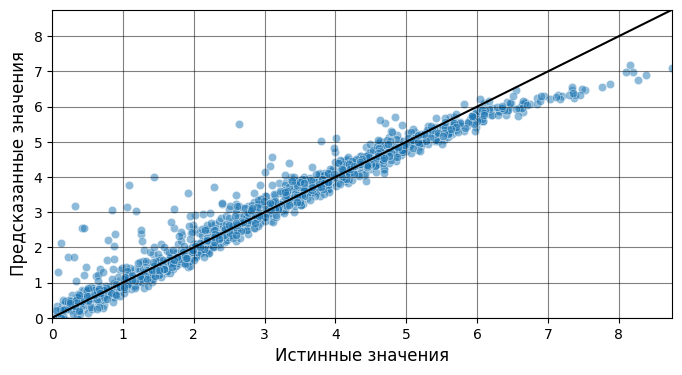

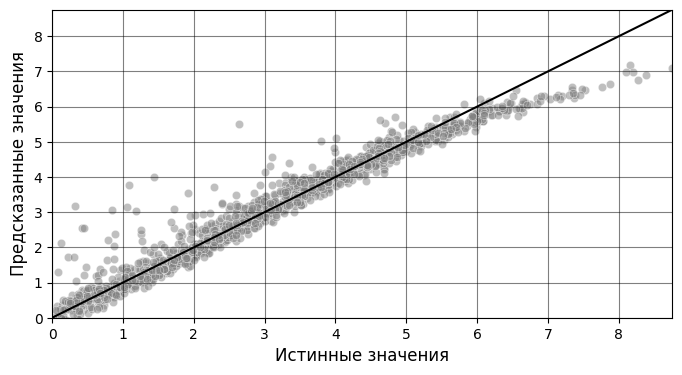

In [17]:
scatter_plot(test_intervals_Y[:,0], pred[:,0], max(test_intervals_Y[:,0]), "/home/jupyter/datasphere/project/" + ROOT_PATH + "/Untitled Folder/val1" + model_path)
scatter_plot(test_intervals_Y[:,1], pred[:,1], max(test_intervals_Y[:,1]), "/home/jupyter/datasphere/project/" + ROOT_PATH + "/Untitled Folder/val2" + model_path)
scatter_plot(test_intervals_Y[:,2], pred[:,2], max(test_intervals_Y[:,2]), "/home/jupyter/datasphere/project/" + ROOT_PATH + "/Untitled Folder/val3" + model_path)
scatter_plot(test_intervals_Y[:,3], pred[:,3], max(test_intervals_Y[:,3]), "/home/jupyter/datasphere/project/" + ROOT_PATH + "/Untitled Folder/val4" + model_path)

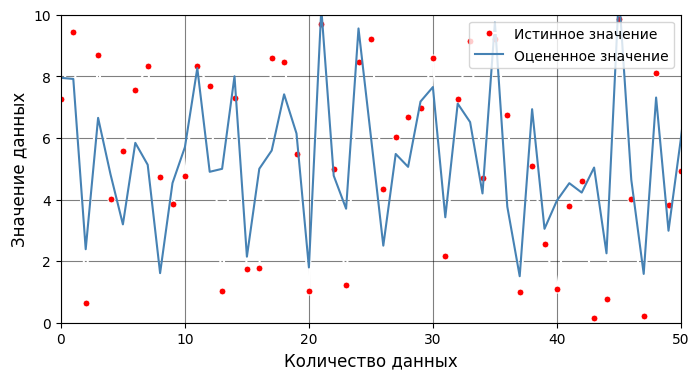

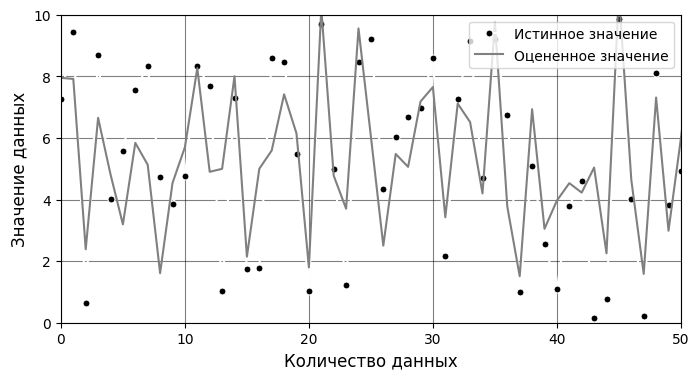

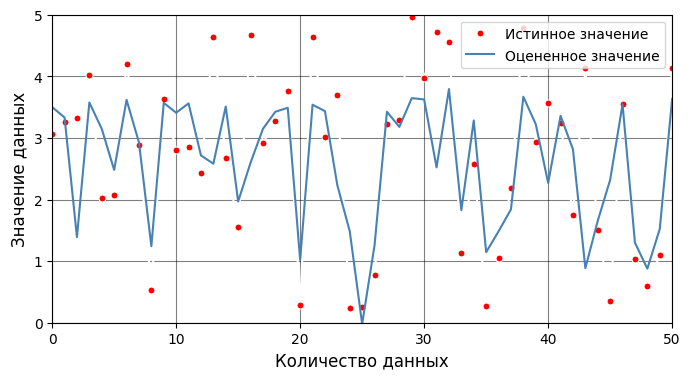

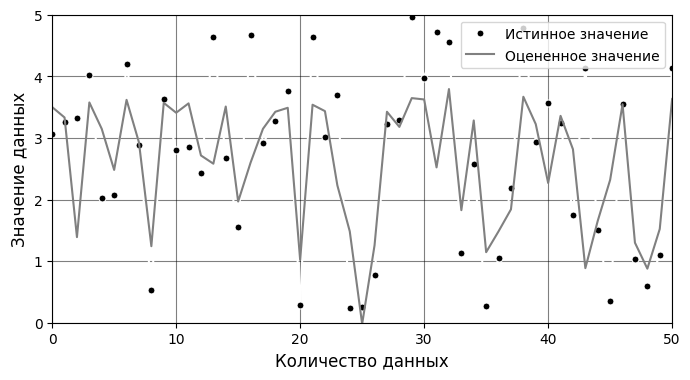

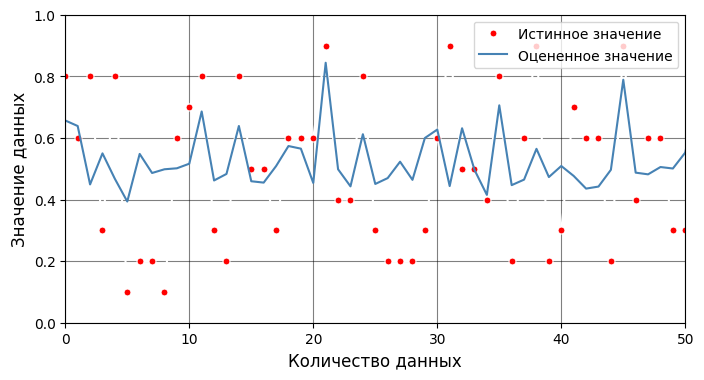

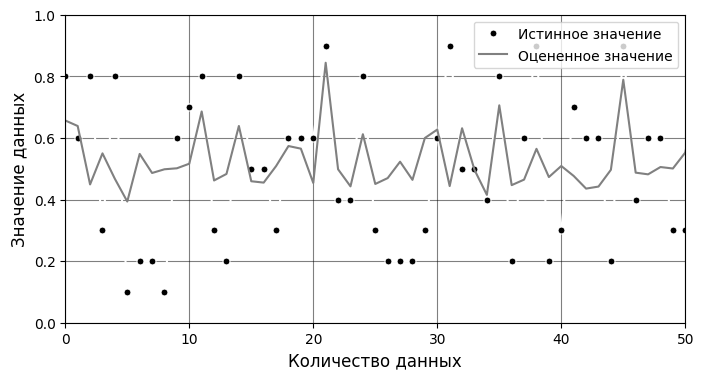

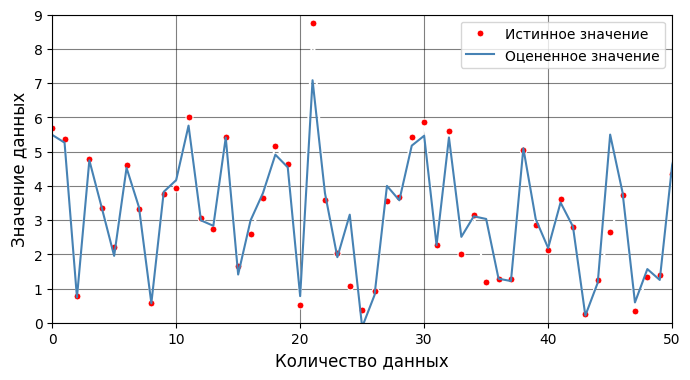

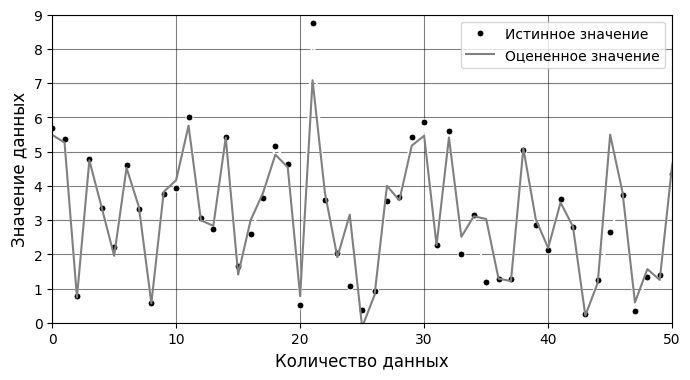

In [18]:
line_plot(test_intervals_Y[:, 0], pred[:, 0], 50, 0, "/home/jupyter/datasphere/project/" + ROOT_PATH + "/Untitled Folder/val1" + model_path + "_line")
line_plot(test_intervals_Y[:, 1], pred[:, 1], 50, 1, "/home/jupyter/datasphere/project/" + ROOT_PATH + "/Untitled Folder/val2" + model_path + "_line")
line_plot(test_intervals_Y[:, 2], pred[:, 2], 50, 2, "/home/jupyter/datasphere/project/" + ROOT_PATH + "/Untitled Folder/val3" + model_path + "_line")
line_plot(test_intervals_Y[:, 3], pred[:, 3], 50, 3, "/home/jupyter/datasphere/project/" + ROOT_PATH + "/Untitled Folder/val4" + model_path + "_line")

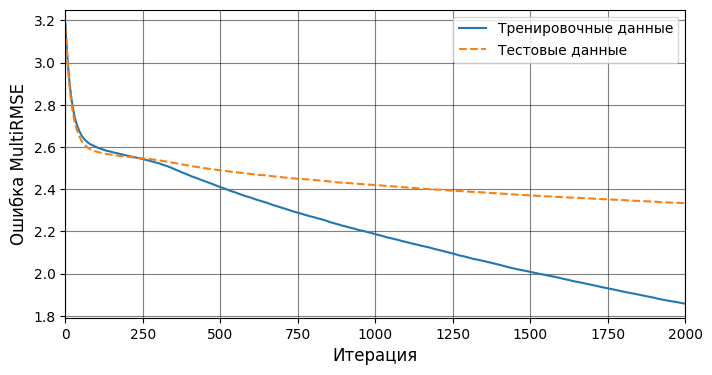

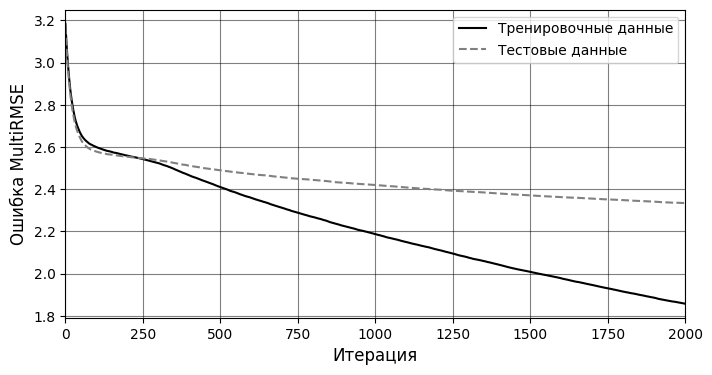

In [19]:
learn_error_df = pd.read_csv('/home/jupyter/datasphere/project/' + ROOT_PATH + '/catboost_info/learn_error.tsv', sep='\t', index_col=0)
test_error_df = pd.read_csv('/home/jupyter/datasphere/project/' + ROOT_PATH + '/catboost_info/test_error.tsv', sep='\t', index_col=0)

plt.figure(figsize=(8, 4))  # Create separate figures
sns.lineplot(np.array([list(row) for _, row in learn_error_df.iterrows()]).flatten().tolist(), label='Тренировочные данные')
sns.lineplot(np.array([list(row) for _, row in test_error_df.iterrows()]).flatten().tolist(), label='Тестовые данные', linestyle='--')  # Simplified
plt.xlim(0, len(learn_error_df))
plt.xlabel('Итерация', fontsize=12)
plt.ylabel('Ошибка MultiRMSE', fontsize=12)
plt.grid(alpha=0.5, color='black')
plt.savefig('/home/jupyter/datasphere/project/' + ROOT_PATH + '/Untitled Folder/catboost_train' + model_path + '_colored.pdf', bbox_inches="tight")

plt.figure(figsize=(8, 4))  # Create separate figures
sns.lineplot(np.array([list(row) for _, row in learn_error_df.iterrows()]).flatten().tolist(), label='Тренировочные данные', color='black')
sns.lineplot(np.array([list(row) for _, row in test_error_df.iterrows()]).flatten().tolist(), label='Тестовые данные', color='gray', linestyle='--')  # Simplified
plt.xlim(0, len(learn_error_df))
plt.xlabel('Итерация', fontsize=12)
plt.ylabel('Ошибка MultiRMSE', fontsize=12)
plt.grid(alpha=0.5, color='black')
plt.savefig('/home/jupyter/datasphere/project/' + ROOT_PATH + '/Untitled Folder/catboost_train' + model_path + '.pdf', bbox_inches="tight")

## Catboost статистика

In [20]:
train_stat_M = calculate_statistics(train_intervals_X)
test_stat_M = calculate_statistics(test_intervals_X)
val_stat_M = calculate_statistics(val_intervals_X)

In [29]:
params = {
    "loss_function": "MultiRMSE",
    "verbose": 500,
    "random_seed": SEED,
    #"task_type": "GPU",  # Уберите, если у вас нет GPU
    "iterations": 2000,
    "early_stopping_rounds": 100,
    #"l2_leaf_reg": 3,
    #"depth": 8,
    #"learning_rate": 0.003
}

stat = CatBoostRegressor(**params)

# Обучение с использованием валидационной выборки
stat.fit(train_stat_M, train_intervals_Y, eval_set=(val_stat_M, val_intervals_Y), use_best_model=True)

0:	learn: 3.5934128	test: 3.5650761	best: 3.5650761 (0)	total: 6.47ms	remaining: 12.9s
500:	learn: 1.4105144	test: 1.3978113	best: 1.3978113 (500)	total: 1.56s	remaining: 4.68s
1000:	learn: 1.2764075	test: 1.3424851	best: 1.3424678 (997)	total: 3.13s	remaining: 3.13s
1500:	learn: 1.1987534	test: 1.3324526	best: 1.3319547 (1484)	total: 4.71s	remaining: 1.57s
1999:	learn: 1.1401176	test: 1.3263622	best: 1.3262435 (1996)	total: 6.29s	remaining: 0us

bestTest = 1.326243486
bestIteration = 1996

Shrink model to first 1997 iterations.


In [22]:
pred = stat.predict(test_stat_M)

In [31]:
stat.save_model(ROOT_PATH + "_stat")

In [21]:
stat = CatBoostRegressor() 
stat.load_model('/home/jupyter/datasphere/project/hexp/models/hexp_stat')
pred = stat.predict(test_intervals_X)

### Метрики

In [24]:
evaluate_regression(test_intervals_Y[:, 0], pred[:, 0], "value1")
evaluate_regression(test_intervals_Y[:, 1], pred[:, 1], "value2")
evaluate_regression(test_intervals_Y[:, 2], pred[:, 2], "value3")
evaluate_regression(test_intervals_Y[:, 3], pred[:, 3], "value4")


value1
MAE: 0.782
MSE: 1.190
RMSE: 1.091
MAPE: 50.602%
R² Score: 0.856

value2
MAE: 0.534
MSE: 0.644
RMSE: 0.802
MAPE: 54.087%
R² Score: 0.694

value3
MAE: 0.144
MSE: 0.036
RMSE: 0.190
MAPE: 50.699%
R² Score: 0.357

value4
MAE: 0.042
MSE: 0.004
RMSE: 0.063
MAPE: 2.122%
R² Score: 0.999


In [34]:
train_df, test_df = train_test_split(df, train_size=0.8, random_state=SEED, shuffle=True)
test_df, val_df = train_test_split(test_df, train_size=0.7, random_state=SEED, shuffle=True)

test_df_X = np.array(test_df)[:, :10000]

test_df_gen = gen_recurr(test_df_X.shape[0], test_df_X.shape[1], pred[:,0], pred[:,1], pred[:,2])

test_interval_df_gen = get_intervals_from_df(test_df_gen.iloc[:, :10000])

In [35]:
a = test_df_X[0:test_df_X.shape[0], :test_df_X.shape[1]]
b = np.array(test_df_gen.iloc[0:test_df_X.shape[0], :test_df_X.shape[1]])

itog_itog_list = []

for i in range(test_df_X.shape[0]):
    itog_list = []
    n_cols = test_df_X.shape[1] # Store this value to avoid repeated access

    if np.max(a[i]) > np.max(b[i]): # Use NumPy's max for efficiency
        counter1 = 0
        counter2 = 0
        while counter1 < n_cols and counter2 < n_cols: #Ensure no index errors
            diff = counter1 - counter2
            if a[i][counter1] < b[i][counter2]:
                counter1 += 1
            elif a[i][counter1] > b[i][counter2]:
                counter2 += 1
            else:
                counter1 += 1
                counter2 += 1
            itog_list.append(abs(diff))
    else:
        counter1 = 0
        counter2 = 0
        while counter1 < n_cols and counter2 < n_cols: #Ensure no index errors
            diff = counter1 - counter2
            if a[i][counter1] < b[i][counter2]:
                counter1 += 1
            elif a[i][counter1] > b[i][counter2]:
                counter2 += 1
            else:
                counter1 += 1
                counter2 += 1
            itog_list.append(abs(diff))

    itog_itog_list.append(itog_list)

In [36]:
print_curve_metrics(test_intervals_df.iloc[:, :9999], test_interval_df_gen, itog_itog_list)

relative_error_mean_mean:	0.330
relative_error_mean_median:	0.054
relative_error_std_mean:	0.372
relative_error_std_median:	0.075
abs_mean:	1660.820
abs_median:	543.000


### Рисунки

In [25]:
model_path = '_stat'

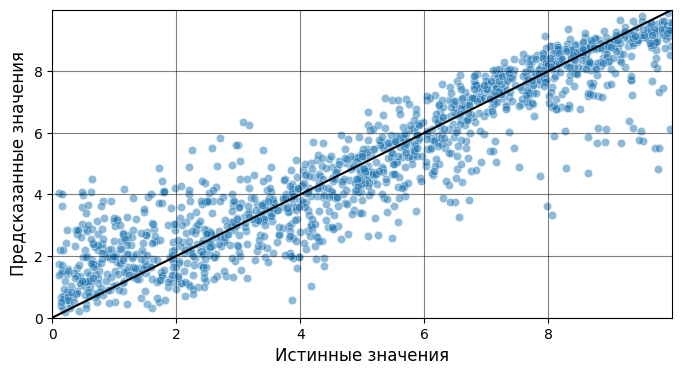

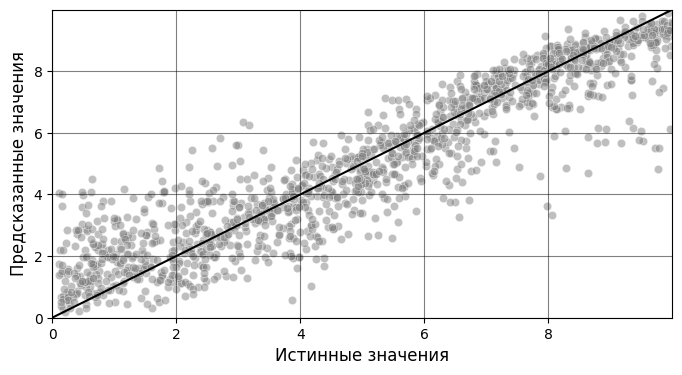

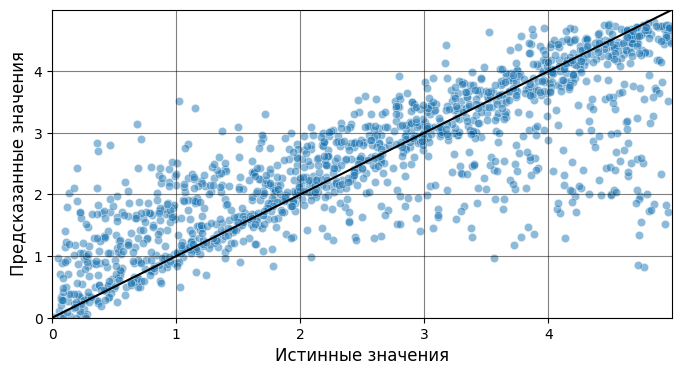

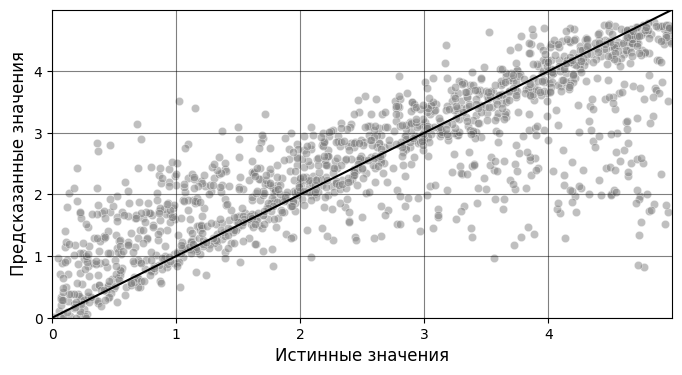

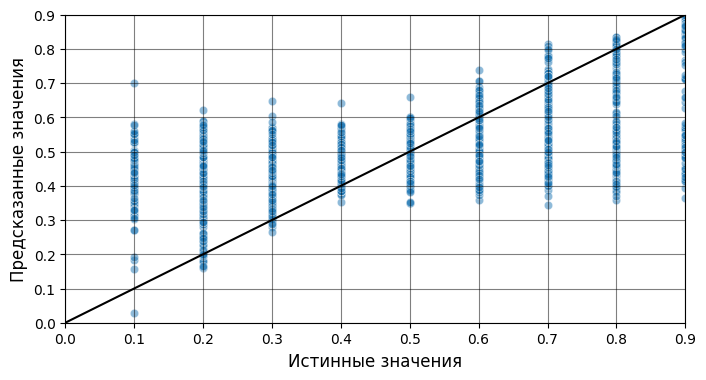

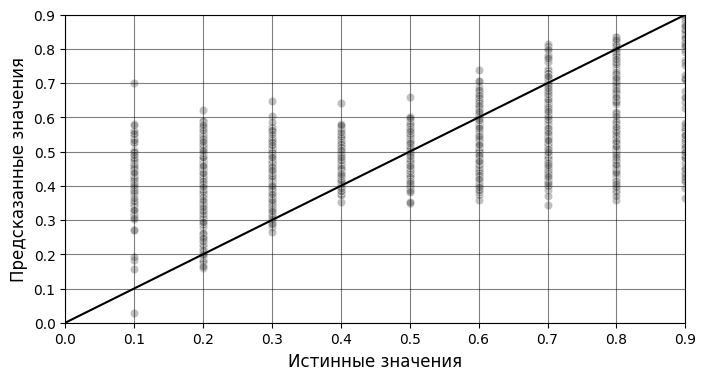

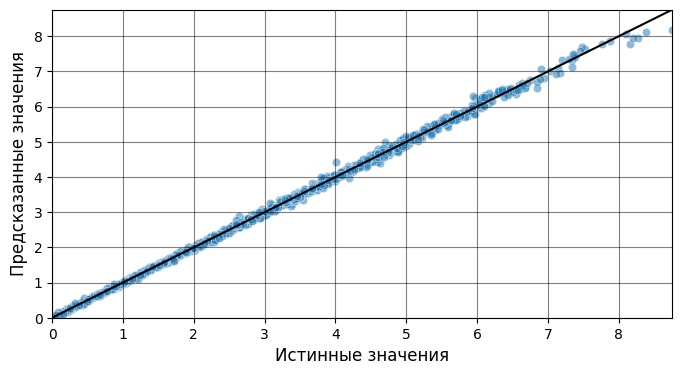

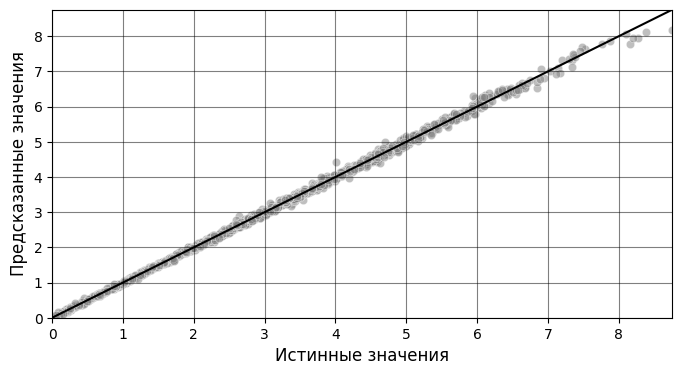

In [30]:
scatter_plot(test_intervals_Y[:,0], pred[:,0], max(test_intervals_Y[:,0]), "/home/jupyter/datasphere/project/" + ROOT_PATH + "/Untitled Folder/val1" + model_path)
scatter_plot(test_intervals_Y[:,1], pred[:,1], max(test_intervals_Y[:,1]), "/home/jupyter/datasphere/project/" + ROOT_PATH + "/Untitled Folder/val2" + model_path)
scatter_plot(test_intervals_Y[:,2], pred[:,2], max(test_intervals_Y[:,2]), "/home/jupyter/datasphere/project/" + ROOT_PATH + "/Untitled Folder/val3" + model_path)
scatter_plot(test_intervals_Y[:,3], pred[:,3], max(test_intervals_Y[:,3]), "/home/jupyter/datasphere/project/" + ROOT_PATH + "/Untitled Folder/val4" + model_path)

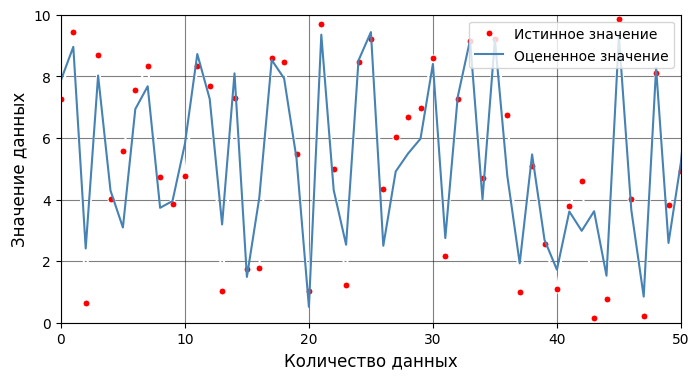

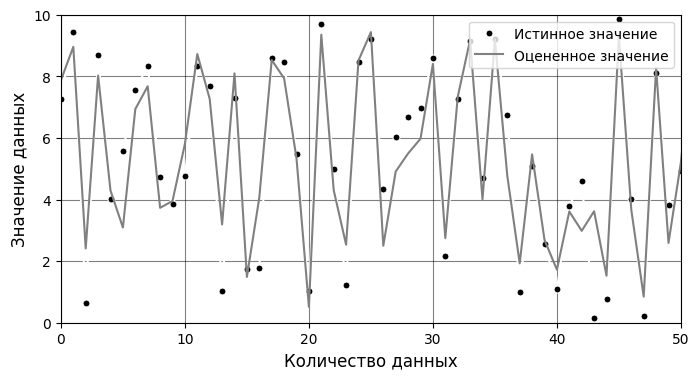

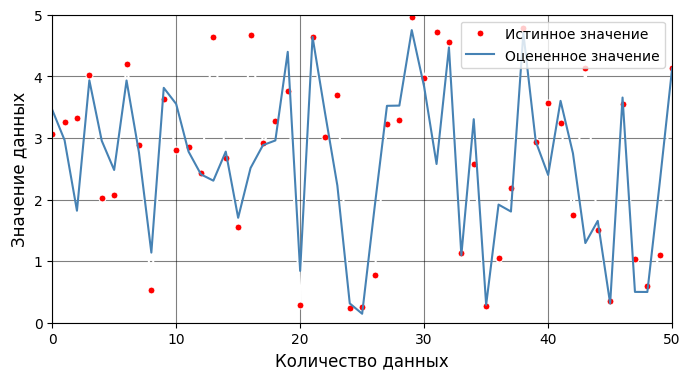

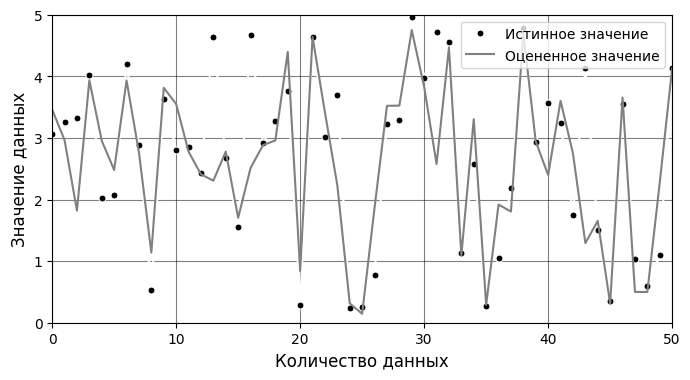

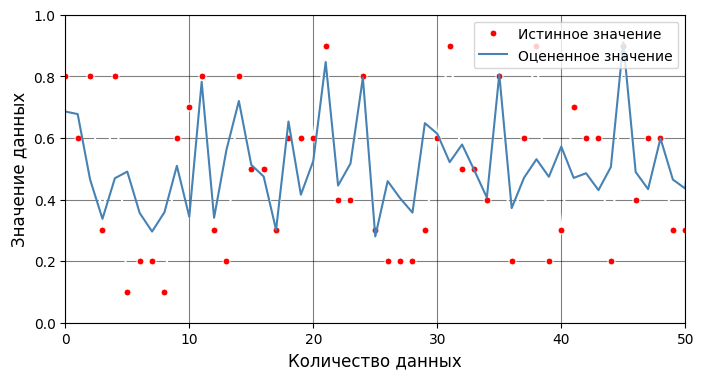

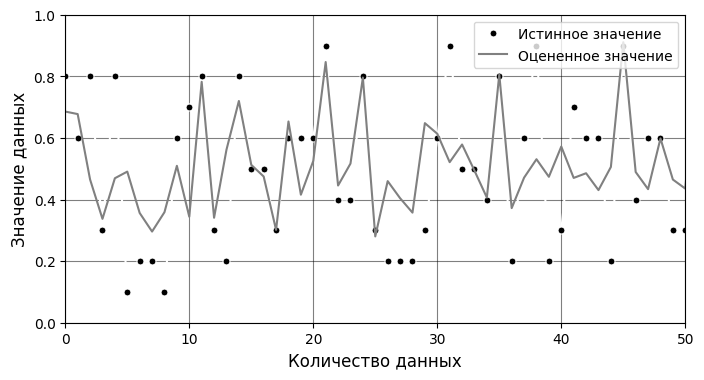

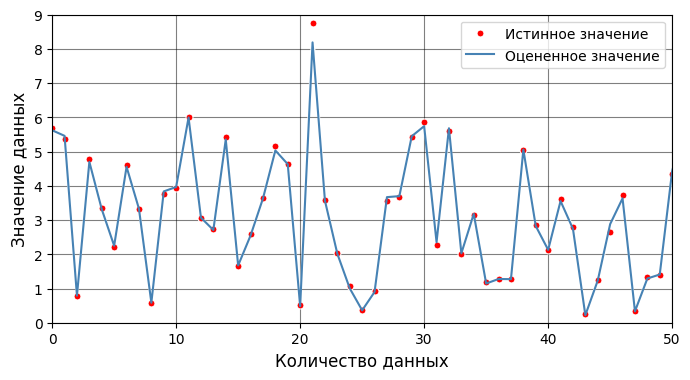

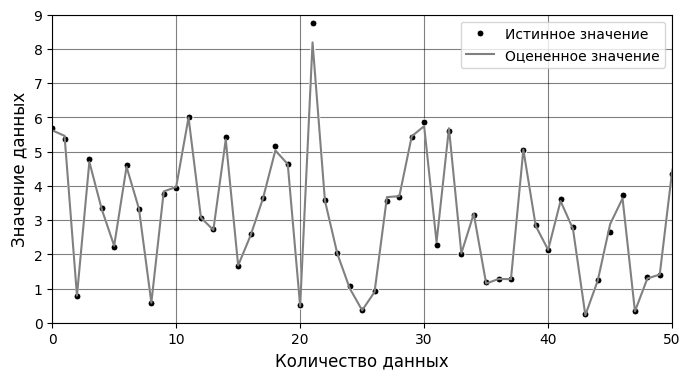

In [29]:
line_plot(test_intervals_Y[:, 0], pred[:, 0], 50, 0, "/home/jupyter/datasphere/project/" + ROOT_PATH + "/Untitled Folder/val1" + model_path + "_line")
line_plot(test_intervals_Y[:, 1], pred[:, 1], 50, 1, "/home/jupyter/datasphere/project/" + ROOT_PATH + "/Untitled Folder/val2" + model_path + "_line")
line_plot(test_intervals_Y[:, 2], pred[:, 2], 50, 2, "/home/jupyter/datasphere/project/" + ROOT_PATH + "/Untitled Folder/val3" + model_path + "_line")
line_plot(test_intervals_Y[:, 3], pred[:, 3], 50, 3, "/home/jupyter/datasphere/project/" + ROOT_PATH + "/Untitled Folder/val4" + model_path + "_line")

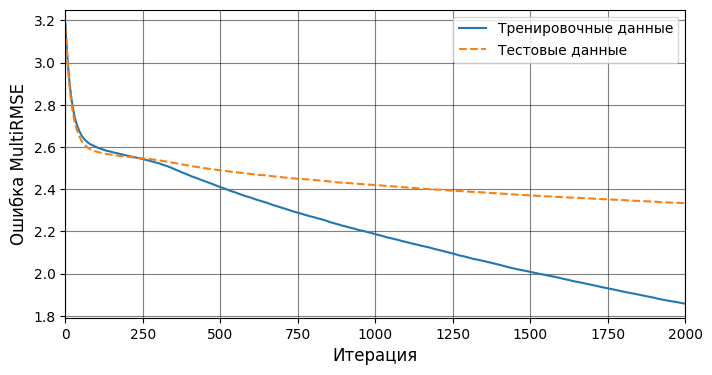

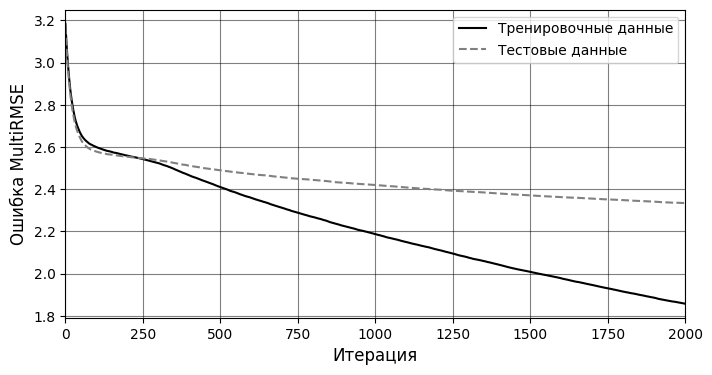

In [32]:
learn_error_df = pd.read_csv('/home/jupyter/datasphere/project/' + ROOT_PATH + '/catboost_info/learn_error.tsv', sep='\t', index_col=0)
test_error_df = pd.read_csv('/home/jupyter/datasphere/project/' + ROOT_PATH + '/catboost_info/test_error.tsv', sep='\t', index_col=0)

plt.figure(figsize=(8, 4))  # Create separate figures
sns.lineplot(np.array([list(row) for _, row in learn_error_df.iterrows()]).flatten().tolist(), label='Тренировочные данные')
sns.lineplot(np.array([list(row) for _, row in test_error_df.iterrows()]).flatten().tolist(), label='Тестовые данные', linestyle='--')  # Simplified
plt.xlim(0, len(learn_error_df))
plt.xlabel('Итерация', fontsize=12)
plt.ylabel('Ошибка MultiRMSE', fontsize=12)
plt.grid(alpha=0.5, color='black')
plt.savefig('/home/jupyter/datasphere/project/' + ROOT_PATH + '/Untitled Folder/catboost_train' + model_path + '_colored.pdf', bbox_inches="tight")

plt.figure(figsize=(8, 4))  # Create separate figures
sns.lineplot(np.array([list(row) for _, row in learn_error_df.iterrows()]).flatten().tolist(), label='Тренировочные данные', color='black')
sns.lineplot(np.array([list(row) for _, row in test_error_df.iterrows()]).flatten().tolist(), label='Тестовые данные', color='gray', linestyle='--')  # Simplified
plt.xlim(0, len(learn_error_df))
plt.xlabel('Итерация', fontsize=12)
plt.ylabel('Ошибка MultiRMSE', fontsize=12)
plt.grid(alpha=0.5, color='black')
plt.savefig('/home/jupyter/datasphere/project/' + ROOT_PATH + '/Untitled Folder/catboost_train' + model_path + '.pdf', bbox_inches="tight")

## Catboost моменты

In [10]:
train_df, test_df = train_test_split(df.iloc[:, :10004], train_size=0.8, random_state=SEED, shuffle=True)

In [11]:
test_df, val_df = train_test_split(df.iloc[:, :10004], train_size=0.7, random_state=SEED, shuffle=True)

In [12]:
train_X = np.array(train_df)[:, :10000]
train_Y = np.array(train_df)[:, 10000:]
test_X = np.array(test_df)[:, :10000]
test_Y = np.array(test_df)[:, 10000:]
val_X = np.array(val_df)[:, :10000]
val_Y = np.array(val_df)[:, 10000:]

In [13]:
params = {
    "loss_function": "MultiRMSE",
    "verbose": 100,
    "random_seed": SEED,
    #"task_type": "GPU",  # Уберите, если у вас нет GPU
    "iterations": 2000,
    "early_stopping_rounds": 200,
    #"l2_leaf_reg": 3,
    #"depth": 8,
    #"learning_rate": 0.03
}

moments = CatBoostRegressor(**params)

# Обучение с использованием валидационной выборки
moments.fit(train_X, train_Y, eval_set=(val_X, val_Y), use_best_model=True)

0:	learn: 3.6107133	test: 3.6132982	best: 3.6132982 (0)	total: 3.62s	remaining: 2h 35s
100:	learn: 2.6098128	test: 2.5890033	best: 2.5890033 (100)	total: 1m 11s	remaining: 22m 24s
200:	learn: 2.5662451	test: 2.5582146	best: 2.5582146 (200)	total: 2m 16s	remaining: 20m 19s
300:	learn: 2.5295771	test: 2.5417761	best: 2.5417750 (299)	total: 3m 20s	remaining: 18m 50s
400:	learn: 2.4720312	test: 2.5154528	best: 2.5154528 (400)	total: 4m 24s	remaining: 17m 35s
500:	learn: 2.4147679	test: 2.4935775	best: 2.4935775 (500)	total: 5m 28s	remaining: 16m 23s
600:	learn: 2.3637086	test: 2.4770781	best: 2.4770781 (600)	total: 6m 32s	remaining: 15m 13s
700:	learn: 2.3165742	test: 2.4617655	best: 2.4617655 (700)	total: 7m 36s	remaining: 14m 5s
800:	learn: 2.2724526	test: 2.4482541	best: 2.4482541 (800)	total: 8m 40s	remaining: 12m 59s
900:	learn: 2.2290873	test: 2.4342352	best: 2.4342352 (900)	total: 9m 44s	remaining: 11m 53s
1000:	learn: 2.1909444	test: 2.4239067	best: 2.4239067 (1000)	total: 10m 48s	

In [15]:
pred = moments.predict(test_X)

In [16]:
moments.save_model(ROOT_PATH + "_moments")

In [37]:
moments = CatBoostRegressor() 
moments.load_model('/home/jupyter/datasphere/project/hexp/models/hexp_moments')
pred = moments.predict(test_X)

### Метрики

In [17]:
evaluate_regression(test_Y[:, 0], pred[:, 0], "value1")
evaluate_regression(test_Y[:, 1], pred[:, 1], "value2")
evaluate_regression(test_Y[:, 2], pred[:, 2], "value3")
evaluate_regression(test_Y[:, 3], pred[:, 3], "value4")


value1
MAE: 1.389
MSE: 2.793
RMSE: 1.671
MAPE: 71.585%
R² Score: 0.661

value2
MAE: 0.626
MSE: 0.651
RMSE: 0.807
MAPE: 49.960%
R² Score: 0.686

value3
MAE: 0.160
MSE: 0.036
RMSE: 0.190
MAPE: 53.577%
R² Score: 0.335

value4
MAE: 0.040
MSE: 0.004
RMSE: 0.066
MAPE: 1.761%
R² Score: 0.999


In [18]:
train_df, test_df = train_test_split(df, train_size=0.8, random_state=SEED, shuffle=True)
test_df, val_df = train_test_split(test_df, train_size=0.7, random_state=SEED, shuffle=True)

test_df_X = np.array(test_df)[:, :10000]

test_df_gen = gen_recurr(test_df_X.shape[0], test_df_X.shape[1], pred[:,0], pred[:,1], pred[:,2])

test_interval_df_gen = get_intervals_from_df(test_df_gen.iloc[:, :10000])

In [19]:
a = test_df_X[0:test_df_X.shape[0], :test_df_X.shape[1]]
b = np.array(test_df_gen.iloc[0:test_df_X.shape[0], :test_df_X.shape[1]])

itog_itog_list = []

for i in range(test_df_X.shape[0]):
    itog_list = []
    n_cols = test_df_X.shape[1] # Store this value to avoid repeated access

    if np.max(a[i]) > np.max(b[i]): # Use NumPy's max for efficiency
        counter1 = 0
        counter2 = 0
        while counter1 < n_cols and counter2 < n_cols: #Ensure no index errors
            diff = counter1 - counter2
            if a[i][counter1] < b[i][counter2]:
                counter1 += 1
            elif a[i][counter1] > b[i][counter2]:
                counter2 += 1
            else:
                counter1 += 1
                counter2 += 1
            itog_list.append(abs(diff))
    else:
        counter1 = 0
        counter2 = 0
        while counter1 < n_cols and counter2 < n_cols: #Ensure no index errors
            diff = counter1 - counter2
            if a[i][counter1] < b[i][counter2]:
                counter1 += 1
            elif a[i][counter1] > b[i][counter2]:
                counter2 += 1
            else:
                counter1 += 1
                counter2 += 1
            itog_list.append(abs(diff))

    itog_itog_list.append(itog_list)

In [25]:
print_curve_metrics(test_intervals_df.iloc[:, :9999], test_interval_df_gen, itog_itog_list)

relative_error_mean_mean:	1.570
relative_error_mean_median:	0.540
relative_error_std_mean:	1.898
relative_error_std_median:	0.569
abs_mean:	4581.164
abs_median:	4413.500


### Рисунки

In [26]:
model_path = '_moments'

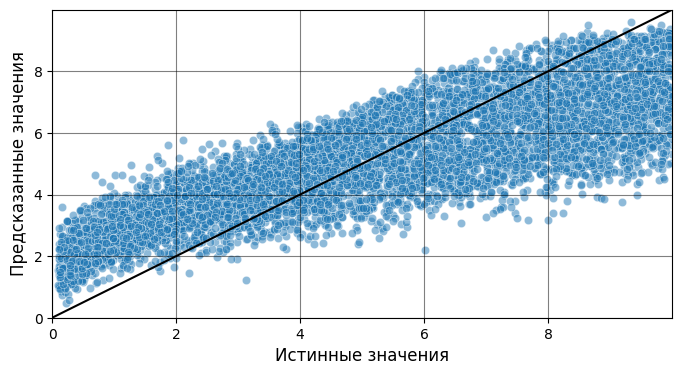

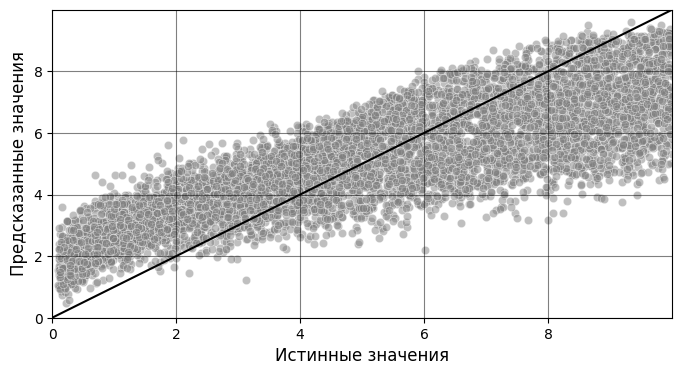

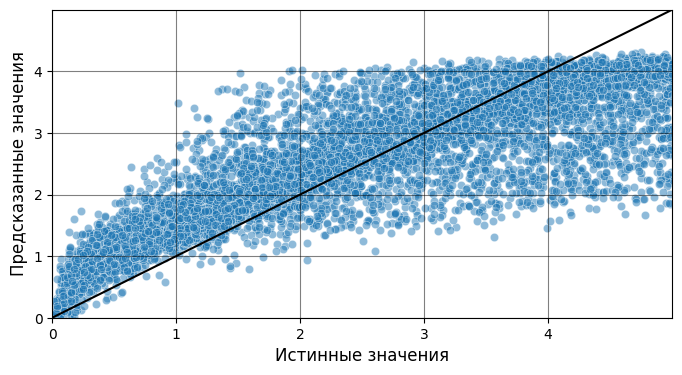

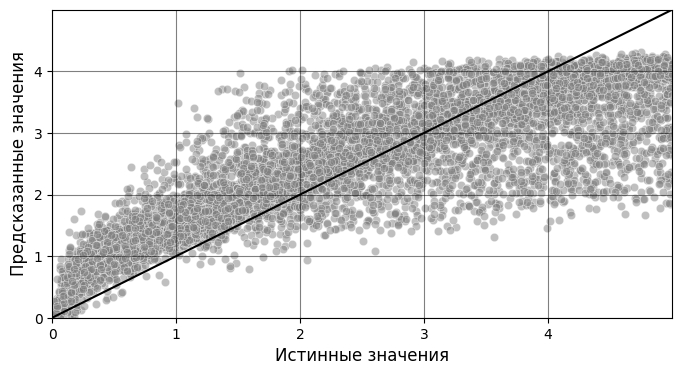

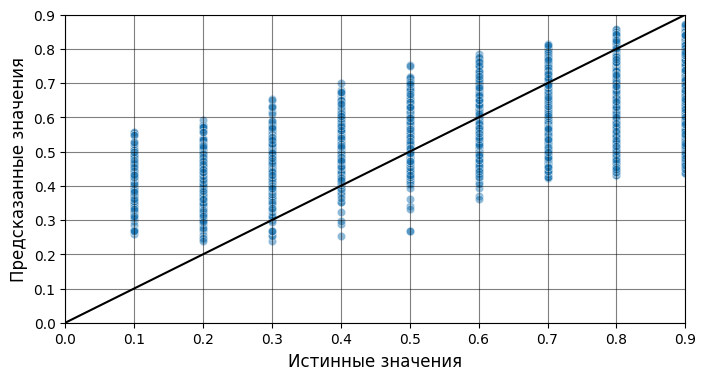

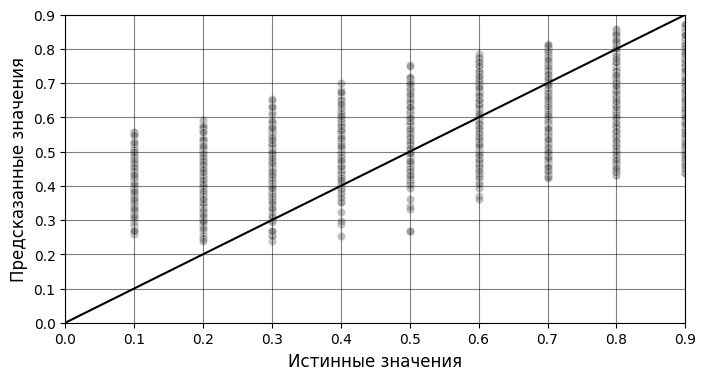

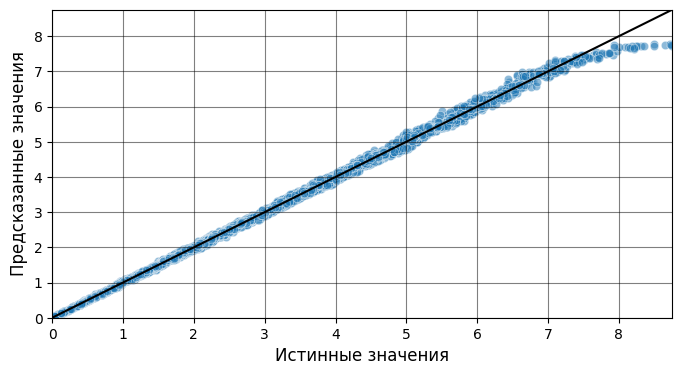

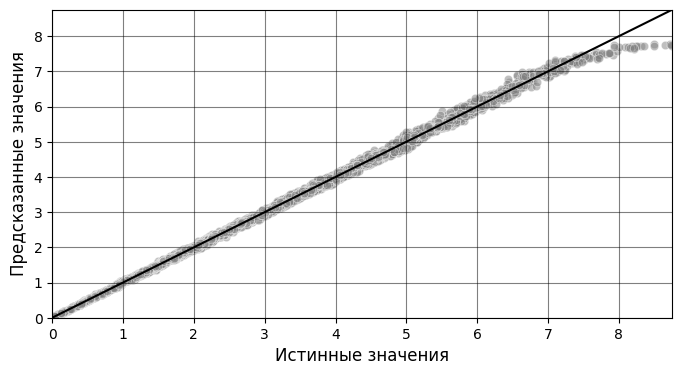

In [27]:
scatter_plot(test_Y[:,0], pred[:,0], max(test_Y[:,0]), "/home/jupyter/datasphere/project/" + ROOT_PATH + "/Untitled Folder/val1" + model_path)
scatter_plot(test_Y[:,1], pred[:,1], max(test_Y[:,1]), "/home/jupyter/datasphere/project/" + ROOT_PATH + "/Untitled Folder/val2" + model_path)
scatter_plot(test_Y[:,2], pred[:,2], max(test_Y[:,2]), "/home/jupyter/datasphere/project/" + ROOT_PATH + "/Untitled Folder/val3" + model_path)
scatter_plot(test_Y[:,3], pred[:,3], max(test_Y[:,3]), "/home/jupyter/datasphere/project/" + ROOT_PATH + "/Untitled Folder/val4" + model_path)

In [28]:
def line_plot(y_test, y_pred, plot_value, value, plot_name=None):

    plot_data = [('white', 'red', '#4682B4', ''), ('white', 'black', 'gray', '_colored')]
    for color, marker_color, line_color, suffix in plot_data:
        plt.figure(figsize=(8, 4))  # Create separate figures
        sns.lineplot(y_test, label='Истинное значение', color=color, marker='o', markersize=5, markerfacecolor=marker_color)
        sns.lineplot(y_pred, label='Оцененное значение', color=line_color)  # Simplified
        plt.xlim(0, plot_value)
        plt.ylim(0, round(max(test_Y[:plot_value, value])))
        plt.xlabel('Количество данных', fontsize=12)
        plt.ylabel('Значение данных', fontsize=12)
        plt.grid(alpha=0.5, color='black')
        plt.legend(loc=1) # Add a legend to distinguish lines

        filename = f'{plot_name}{suffix}.pdf' if plot_name else None
        if filename:
            plt.savefig(f'{filename}', bbox_inches="tight")

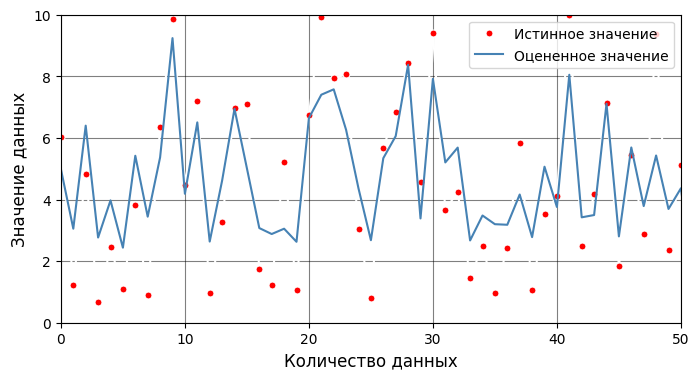

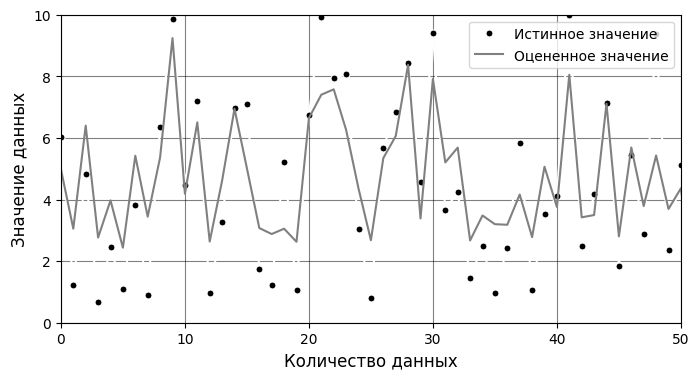

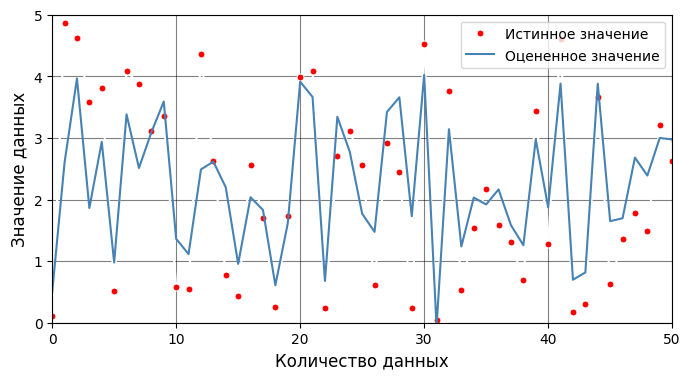

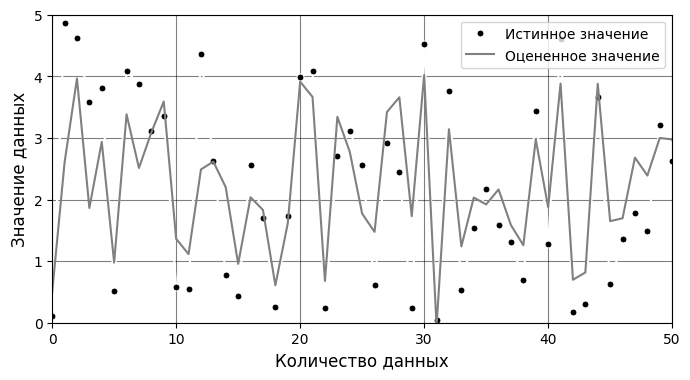

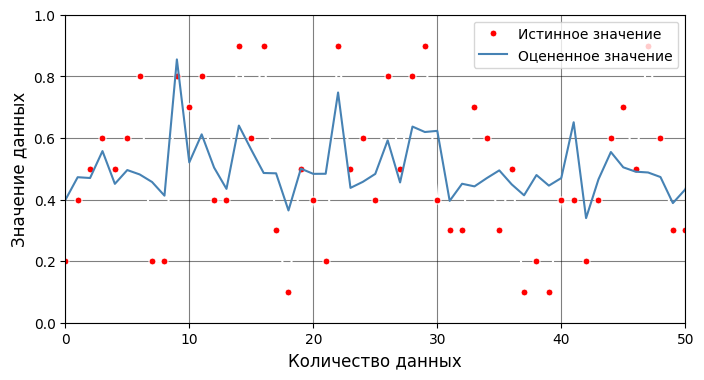

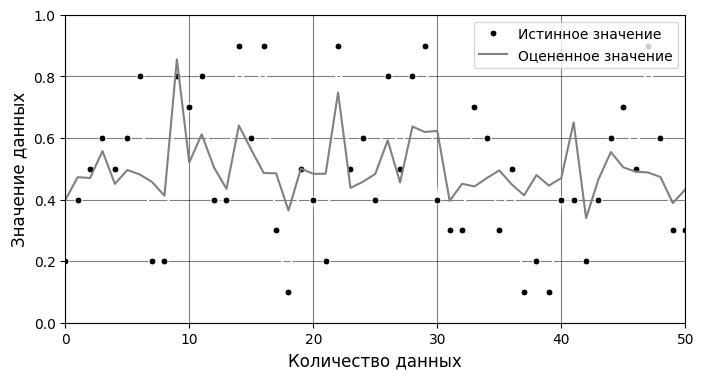

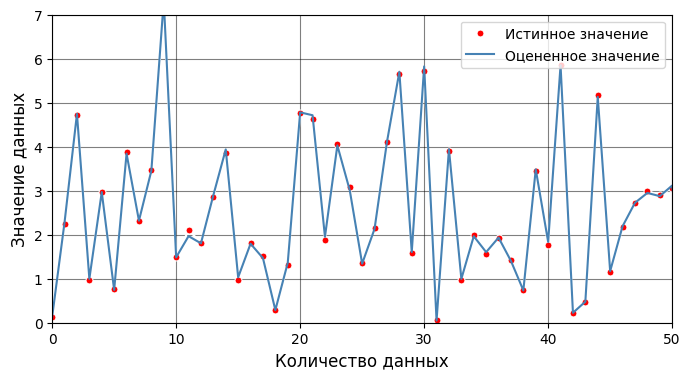

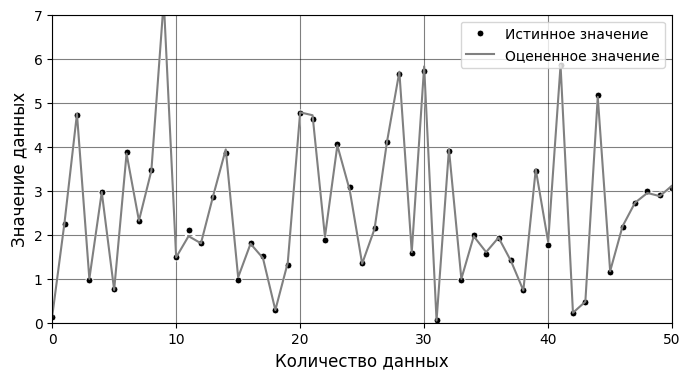

In [29]:
line_plot(test_Y[:, 0], pred[:, 0], 50, 0, "/home/jupyter/datasphere/project/" + ROOT_PATH + "/Untitled Folder/val1" + model_path + "_line")
line_plot(test_Y[:, 1], pred[:, 1], 50, 1, "/home/jupyter/datasphere/project/" + ROOT_PATH + "/Untitled Folder/val2" + model_path + "_line")
line_plot(test_Y[:, 2], pred[:, 2], 50, 2, "/home/jupyter/datasphere/project/" + ROOT_PATH + "/Untitled Folder/val3" + model_path + "_line")
line_plot(test_Y[:, 3], pred[:, 3], 50, 3, "/home/jupyter/datasphere/project/" + ROOT_PATH + "/Untitled Folder/val4" + model_path + "_line")

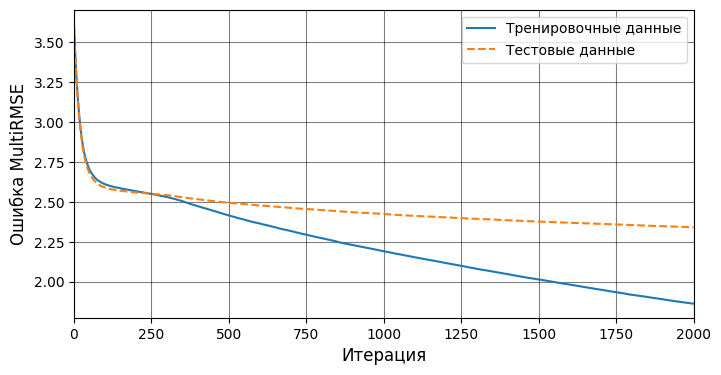

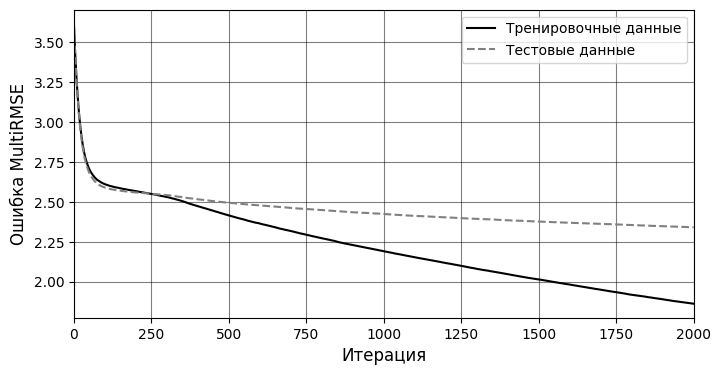

In [30]:
learn_error_df = pd.read_csv('/home/jupyter/datasphere/project/' + ROOT_PATH + '/catboost_info/learn_error.tsv', sep='\t', index_col=0)
test_error_df = pd.read_csv('/home/jupyter/datasphere/project/' + ROOT_PATH + '/catboost_info/test_error.tsv', sep='\t', index_col=0)

plt.figure(figsize=(8, 4))  # Create separate figures
sns.lineplot(np.array([list(row) for _, row in learn_error_df.iterrows()]).flatten().tolist(), label='Тренировочные данные')
sns.lineplot(np.array([list(row) for _, row in test_error_df.iterrows()]).flatten().tolist(), label='Тестовые данные', linestyle='--')  # Simplified
plt.xlim(0, len(learn_error_df))
plt.xlabel('Итерация', fontsize=12)
plt.ylabel('Ошибка MultiRMSE', fontsize=12)
plt.grid(alpha=0.5, color='black')
plt.savefig('/home/jupyter/datasphere/project/' + ROOT_PATH + '/Untitled Folder/catboost_train' + model_path + '_colored.pdf', bbox_inches="tight")

plt.figure(figsize=(8, 4))  # Create separate figures
sns.lineplot(np.array([list(row) for _, row in learn_error_df.iterrows()]).flatten().tolist(), label='Тренировочные данные', color='black')
sns.lineplot(np.array([list(row) for _, row in test_error_df.iterrows()]).flatten().tolist(), label='Тестовые данные', color='gray', linestyle='--')  # Simplified
plt.xlim(0, len(learn_error_df))
plt.xlabel('Итерация', fontsize=12)
plt.ylabel('Ошибка MultiRMSE', fontsize=12)
plt.grid(alpha=0.5, color='black')
plt.savefig('/home/jupyter/datasphere/project/' + ROOT_PATH + '/Untitled Folder/catboost_train' + model_path + '.pdf', bbox_inches="tight")